In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time

# Set the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load the data
path = 'MSFT_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


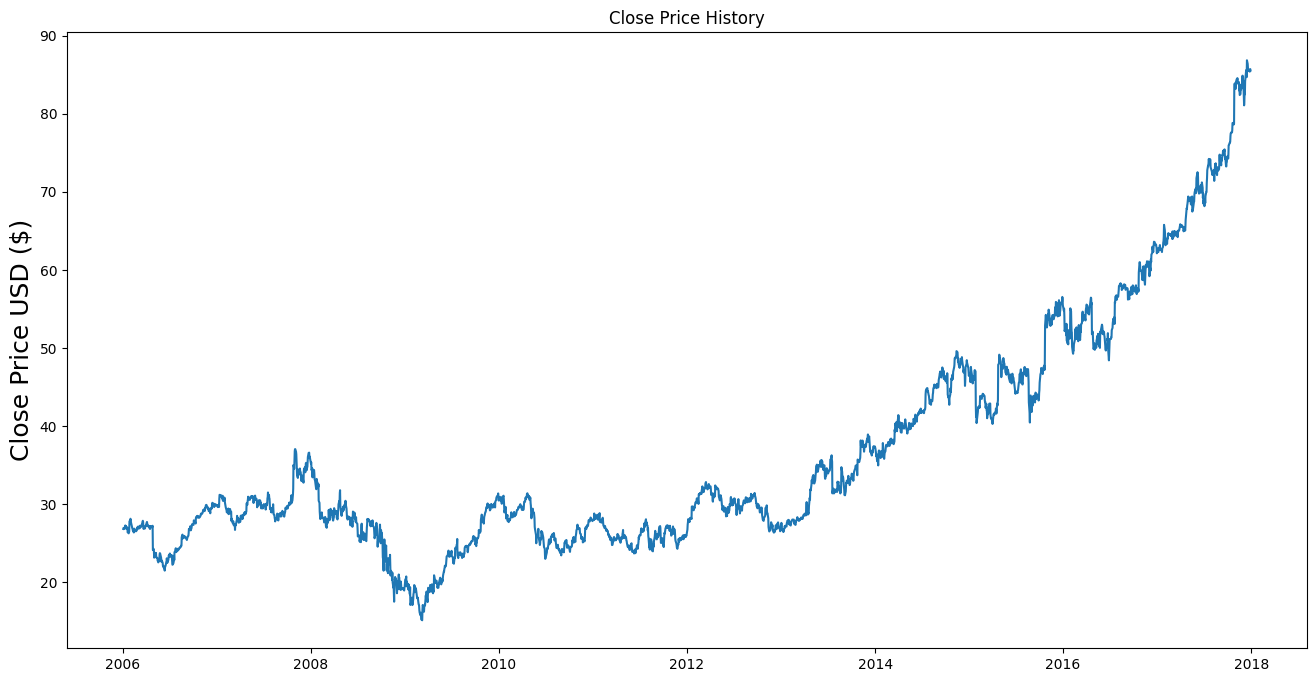

In [8]:
df.Date = pd.to_datetime(df.Date) # Convert the date to datetime for better plotting
df = df.set_index('Date') # Set the date as the index 
df = df.sort_index()

# Plotting Close Price history 
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [9]:
#Data Preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1)) # Normalize the data for better performance 

# Split the data into training and test sets with a lookback of 14 days
def split_data(stock, lookback):
    data_raw = stock.copy() # convert to numpy array
    data = []
    
    # create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    
    test_set_size = int(np.round(0.20 * data.shape[0]))  # Update test set size to 20%
    train_set_size = data.shape[0] - test_set_size  # Update train set size accordingly
    
    x_train = data[:train_set_size, :, ] # Extract the features from the training set
    y_train = data[:train_set_size, -1] # Extract the target from the training set
    
    x_test = data[train_set_size:, :] # Extract the features from the test set
    y_test = data[train_set_size:, -1] # Extract the target from the test set
    
    return [x_train, y_train, x_test, y_test]

lookback = 14 # choose sequence length
X_train, y_train, X_test, y_test = split_data(df['Close'].values, lookback)


# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#Reshape the data to 3D for LSTM input (batch_size, seq, input_size)
X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])
y_train = y_train.view([y_train.shape[0], 1])
y_test = y_test.view([y_test.shape[0], 1])

#Creating Tensor Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [10]:
#Define the model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # LSTM layer
        self.dropout = nn.Dropout(p=dropout) # Dropout layer to prevent overfitting
        self.fc1 = nn.Linear(hidden_dim, int(hidden_dim/2)) # Fully connected layer
        self.fc2 = nn.Linear(int(hidden_dim/2), output_dim) # Fully connected layer
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device) # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device) # Internal state
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # LSTM output
        out = self.dropout(out) # Dropout layer
        out = self.fc1(out[:, -1, :]) # Fully connected layer
        out = self.fc2(out) # Fully connected layer
        return out


In [11]:
#Instantiate the model
input_dim = 1
hidden_dim = 256
output_dim = 1
num_layers = 1
dropout = 0.35

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout=dropout)
model.to(device) 

#Training Loop
num_epochs = 100
alpha = 0.001

criterion = nn.MSELoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=alpha) # Optimizer

#Scheduler to reduce learning rate when the loss becomes constant
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5) 

#Training Loop
hist_train = np.zeros(num_epochs) 
hist_test = np.zeros(num_epochs)
start_time = time.time()
print('Training...')

for epoch in range(num_epochs):
    model.train()
    for i, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)  
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        hist_train[epoch] += loss.item()
    model.eval()
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)  
            loss = criterion(outputs, y_batch)
            hist_test[epoch] += loss.item()
            
    hist_train[epoch] /= len(train_loader)
    hist_test[epoch] /= len(test_loader)
    
    scheduler.step(hist_test[epoch])
    print('Epoch: ', epoch, 'Train Loss: ', hist_train[epoch], 'Test Loss: ', hist_test[epoch])
print('Training Time: ', time.time()-start_time)

Training...
Epoch:  0 Train Loss:  0.05561179736641383 Test Loss:  0.22087429488371862
Epoch:  1 Train Loss:  0.03139118049722655 Test Loss:  0.22739271539582037
Epoch:  2 Train Loss:  0.026538094614424107 Test Loss:  0.15238251882654272
Epoch:  3 Train Loss:  0.023983177450166916 Test Loss:  0.12837421543602096
Epoch:  4 Train Loss:  0.01958287235251383 Test Loss:  0.10512432051626475
Epoch:  5 Train Loss:  0.014887482851535376 Test Loss:  0.03460138813764053
Epoch:  6 Train Loss:  0.008270538328169527 Test Loss:  0.001998590323828945
Epoch:  7 Train Loss:  0.0024854659078348625 Test Loss:  0.002766540823167337
Epoch:  8 Train Loss:  0.0009485153963109233 Test Loss:  0.002119935184294407
Epoch:  9 Train Loss:  0.0009835870658111833 Test Loss:  0.0014444411859394198
Epoch:  10 Train Loss:  0.0009974452259484679 Test Loss:  0.0007066452729448333
Epoch:  11 Train Loss:  0.0012349314351204636 Test Loss:  0.00045051011884903635
Epoch:  12 Train Loss:  0.002098312941310915 Test Loss:  0.000

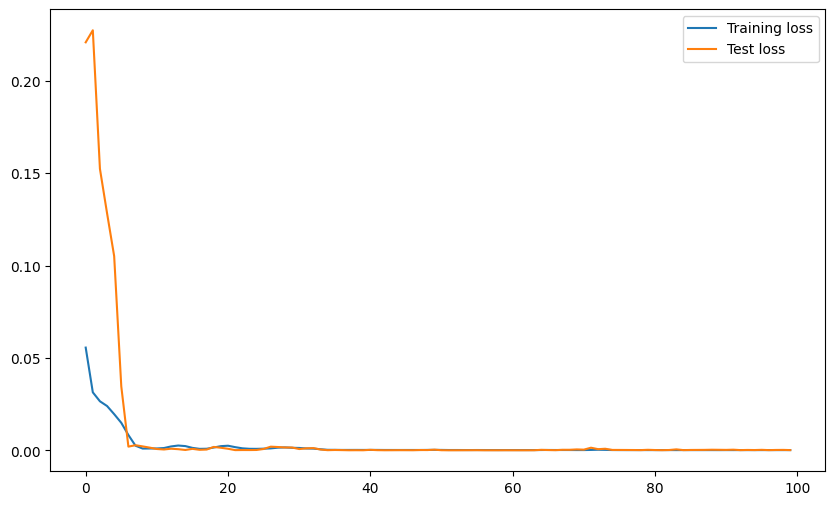

In [12]:
#plotting Train vs Test Loss
plt.figure(figsize=(10, 6))
plt.plot(hist_train, label="Training loss")
plt.plot(hist_test, label="Test loss")
plt.legend()
plt.show()

In [13]:
#Predictions

#Plotting Predictions vs Actual values
from itertools import cycle
import plotly.express as px
#Making Predictions
x_train, y_train = train_loader.dataset.tensors
x_test, y_test = test_loader.dataset.tensors

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    y_train_pred = model(x_train)
    y_test_pred = model(x_test)
    print(y_train_pred.size(), y_test_pred.size())

#Ensure the data is on the cpu to use numpy
y_train_pred = torch.Tensor.cpu(y_train_pred).detach().numpy()
y_test_pred = torch.Tensor.cpu(y_test_pred).detach().numpy()

#Inverse Transform
y_train_pred = scaler.inverse_transform(y_train_pred) 
y_test_pred = scaler.inverse_transform(y_test_pred) 

df['Close'] = scaler.inverse_transform(df[['Close']])

# shift train predictions for plotting
trainPredictPlot = np.empty((len(df), 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred[:len(y_train_pred)]

# shift test predictions for plotting
testPredictPlot = np.empty((len(df), 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(lookback):len(df), :] = y_test_pred[:len(y_test_pred)]

print("Train predicted data: ", y_train_pred.shape)
print("Test predicted data: ", y_test_pred.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': df.index,
                       'original_close': df['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price (LSTM)',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

torch.Size([2404, 1]) torch.Size([601, 1])
Train predicted data:  (2404, 1)
Test predicted data:  (601, 1)


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt


y_train = torch.Tensor.cpu(y_train).detach().numpy()
y_test = torch.Tensor.cpu(y_test).detach().numpy()

#Calcutating MSE 
trainScore_mse = mean_squared_error(df['Close'][len(y_train_pred)+(lookback):len(df)], y_test_pred[:,0])
print('Train Score: %.3f MSE' % (trainScore_mse))
testScore_mse = mean_squared_error(df['Close'][len(y_train_pred)+(lookback):len(df)], y_test_pred[:,0])
print('Test Score: %.2f MSE' % (testScore_mse))
#Calculating RMSE
trainScore_rmse = sqrt(mean_squared_error(df['Close'][lookback:len(y_train_pred)+lookback], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_rmse))
testScore_rmse = sqrt(mean_squared_error(df['Close'][len(y_train_pred)+(lookback):len(df)], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore_rmse))
#Calculating MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
trainScore_mape = mean_absolute_percentage_error(df['Close'][lookback:len(y_train_pred)+lookback], y_train_pred[:,0])
print('Train Score: %.2f MAPE' % (trainScore_mape))
testScore_mape = mean_absolute_percentage_error(df['Close'][len(y_train_pred)+(lookback):len(df)], y_test_pred[:,0])
print('Test Score: %.2f MAPE' % (testScore_mape))    

#Model hyperparameters and layers to a dictinoary
model_hyperparameters = {
                        'lookback': lookback,
                        'hidden_dim': hidden_dim, 
                        'num_layers': num_layers, 
                        'epochs': num_epochs,
                        'learning_rate': alpha,
                        'batch_size': batch_size,
                        'criterion': 'MSELoss',
                        'optimizer': 'Adam',
                        'scheduler': 'ReduceLROnPlateau',
                        'dropout': dropout,
                        'patience': 10
                        }
model_scores = {
                'train_mse': round(trainScore_mse, 2),
                'test_mse': round(testScore_mse, 2),
                'train_rmse': round(trainScore_rmse, 2),
                'test_rmse': round(testScore_rmse, 2),
                'train_mape': round(trainScore_mape, 2),
                'test_mape': round(testScore_mape, 2),
                }

#Printing scores to a file
with open('LSTM_scores_smalldataset.txt', 'a') as f:
    f.write('LSTM Model\n')
    for key, value in model_hyperparameters.items():
        f.write('%s: %s\n' % (key, value))
    f.write('\n')
    for key, value in model_scores.items():
        f.write('%s: %s\n' % (key, value))
    f.write('--------------------------------\n')
    f.close()


Train Score: 0.772 MSE
Test Score: 0.77 MSE
Train Score: 0.52 RMSE
Test Score: 0.88 RMSE
Train Score: 1.25 MAPE
Test Score: 1.05 MAPE
Model saved
